# Bird image classification 🦜


In [1]:
import numpy as np
import pandas as pd
import torch
from IPython.display import display, Image
print(f"Pytorch version: {torch.__version__} ")
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")
print(torch.version.cuda)

Pytorch version: 1.13.1+cu116 
11.6


### Accessing the data

Let's start with `birds.csv` which contains all of the image ID's and their assosciated bird breed (our data and labels).

In [2]:
labels_csv = pd.read_csv("./birds.csv") #Entire train, valid, and test set
labels_train = labels_csv.loc[(labels_csv['data set'] == 'train') & labels_csv['labels']]    #Just train set
#print(labels_csv.describe())
#print(labels_csv.head())
print(labels_train.describe())
print(labels_train.head())
print("Unique breeds:", len(labels_train['class id'].unique()))

           class id
count  70626.000000
mean     225.117138
std      130.140774
min        0.000000
25%      112.000000
50%      226.000000
75%      337.000000
max      449.000000
   class id                      filepaths           labels  \
0         0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER   
1         0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER   
2         0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER   
3         0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER   
4         0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER   

       scientific label data set  
0  Malacocincla abbotti    train  
1  Malacocincla abbotti    train  
2  Malacocincla abbotti    train  
3  Malacocincla abbotti    train  
4  Malacocincla abbotti    train  
Unique breeds: 450


Looking at this, we can see there are 70626 different images and 450 different breeds.

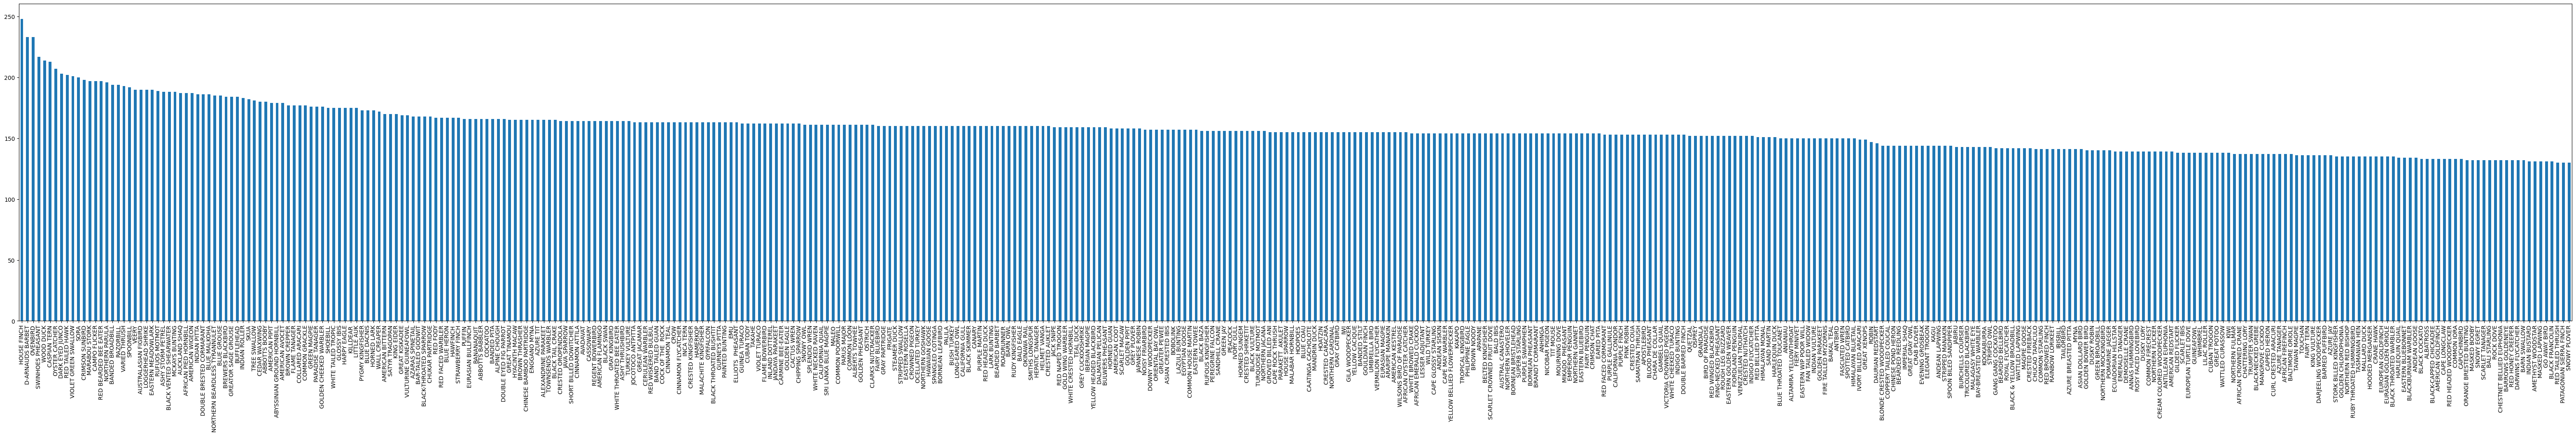

In [3]:
labels_train['labels'].value_counts().plot.bar(figsize=(80, 10));

If we roughly draw a line across the middle of the graph, we'd see there's about 150+ images for each bird breed/

This is a good amount as for some of their vision products [Google recommends a minimum of 10 images per class to get started](https://cloud.google.com/vision/automl/object-detection/docs/prepare). And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.

Let's check out one of the images.

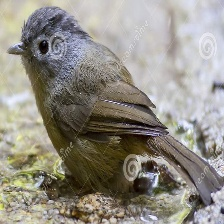

In [4]:
Image('data/train/ABBOTTS BABBLER/001.jpg')

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`labels_train`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [5]:
#Create pathnames from image filepaths
filenames_train = ["data/" + fname for fname in labels_train["filepaths"]]

#Check the first 10 filenames
filenames_train[:10]

['data/train/ABBOTTS BABBLER/001.jpg',
 'data/train/ABBOTTS BABBLER/002.jpg',
 'data/train/ABBOTTS BABBLER/003.jpg',
 'data/train/ABBOTTS BABBLER/004.jpg',
 'data/train/ABBOTTS BABBLER/005.jpg',
 'data/train/ABBOTTS BABBLER/006.jpg',
 'data/train/ABBOTTS BABBLER/007.jpg',
 'data/train/ABBOTTS BABBLER/008.jpg',
 'data/train/ABBOTTS BABBLER/009.jpg',
 'data/train/ABBOTTS BABBLER/010.jpg']

In [6]:
import os
count = 0
for root_dir, cur_dir, files in os.walk('data/train'):  # train folder contains subdirectories (species) with about
    count += len(files)                                 # 150 jpgs for each species

if count == len(filenames_train):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


Let's check if this worked. Visualizing directly from a filepath

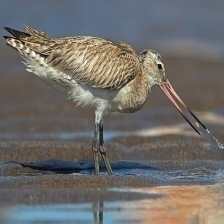

In [7]:
Image(filenames_train[9000])

Let's get the labels now.
We'll take them from `labels_train` and turn them into a NumPy array.

In [8]:
labels = labels_train['labels'].to_numpy()
labels[:10]

array(['ABBOTTS BABBLER', 'ABBOTTS BABBLER', 'ABBOTTS BABBLER',
       'ABBOTTS BABBLER', 'ABBOTTS BABBLER', 'ABBOTTS BABBLER',
       'ABBOTTS BABBLER', 'ABBOTTS BABBLER', 'ABBOTTS BABBLER',
       'ABBOTTS BABBLER'], dtype=object)

Same thing as before, let's check and compare the amount of labels to the number of filenames.

In [9]:
if len(labels) == len(filenames_train):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


If it all worked, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what `labels` currently is), we'll have to convert our labels to numbers.

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).

In [10]:
unique_breeds = np.unique(labels)
len(unique_breeds)

450

In [11]:
unique_breeds

array(['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL',
       'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO',
       'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER',
       'AFRICAN PIED HORNBILL', 'ALBATROSS', 'ALBERTS TOWHEE',
       'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT',
       'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT',
       'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN WIGEON',
       'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING',
       'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD',
       'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD',
       'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD',
       'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'AUCKLAND SHAQ',
       'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT',
       'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY',
       'AZURE TANAGER',

The length of `unique_breeds` should be 120, meaning we're working with images of 120 different breeds of birds.

Now use `unique_breeds` to help turn our `labels` array into an array of booleans.

In [12]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

ABBOTTS BABBLER


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

That's for one example, let's do the whole thing.

In [13]:
# Turn every label into a boolean array
boolean_labels_train = [label == np.array(unique_breeds) for label in labels]
boolean_labels_train[:2]

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

Why do it like this?

Remember, an important concept in machine learning is converting your data to numbers before passing it to a machine learning model.

In this case, we've transformed a single bird breed name such as `ABBOTTS BABBLER` into a one-hot array.

Let's see an example.

In [14]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels_train[0].argmax()) # index where label occurs in boolean array
print(boolean_labels_train[0].astype(int)) # there will be a 1 where the sample label occurs

ABBOTTS BABBLER
0
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


## Now, preprocessing for the validation set
We will perform the same actions we did for the training set.

In [15]:
labels_validation = labels_csv.loc[(labels_csv['data set'] == 'valid') & labels_csv['labels']]    #Just validation set
filenames_valid = ["data/" + fname for fname in labels_validation["filepaths"]]
labels_valid = labels_validation['labels'].to_numpy()
unique_breeds_valid = np.unique(labels_valid)
boolean_labels_valid = [label == np.array(unique_breeds_valid) for label in labels_valid]

Let's check to see if everything is working

In [16]:
# Example: Turning a boolean array into integers
print(labels_valid[0]) # original label
print(np.where(unique_breeds_valid == labels_valid[0])[0][0]) # index where label occurs
print(boolean_labels_valid[0].argmax()) # index where label occurs in boolean array
print(boolean_labels_valid[0].astype(int)) # there will be a 1 where the sample label occurs

ABBOTTS BABBLER
0
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [17]:
X_train = filenames_train
y_train = boolean_labels_train
X_val = filenames_valid
y_val = boolean_labels_valid
len(X_train), len(y_train), len(X_val), len(y_val)

(70626, 70626, 2250, 2250)

In [18]:
# Check out the training data (image file paths and labels
X_train[:5], y_train[:5]

(['data/train/ABBOTTS BABBLER/001.jpg',
  'data/train/ABBOTTS BABBLER/002.jpg',
  'data/train/ABBOTTS BABBLER/003.jpg',
  'data/train/ABBOTTS BABBLER/004.jpg',
  'data/train/ABBOTTS BABBLER/005.jpg'],
 [array([ True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
       

### Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using PyTorch, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how PyTorch stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Takes an image filename as input.
2. Uses PyTorch to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (150, 150).
5. Return the modified `image`.

A good place to read about this type of function is the [PyTorch documentation on loading images](https://pytorch.org/docs/stable/data.html).

You might be wondering why (224, 224), which is (height, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is (224, 224, 3).

What? Where's the 3 from? We're getting ahead of ourselves but that's the number of colour channels per pixel, red, green and blue.

Let's make this a little more concrete.

**Note**: If you are running this **locally**, follow these [instructions](https://pytorch.org/get-started/locally/) to setup PyTorch and also make sure you have [CUDA Toolkit 12.0](https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=10&target_type=exe_network) - more info at [CUDA NVIDIA (for windows)](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html)